# Partial Illumination 

Another notebook in the series of analysis of Mark's trap array design. 

For an array of dark traps, what is the effect of illuminating the mask with a beam that does illuminate the whole array?
A convolution theorem argument can be made to reason that the output array of traps will not go to zero intensity in the centers.

In [1]:
## general imports
import numpy as np
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift

from scipy.special import j0, j1
from matplotlib import colors
import matplotlib.pyplot as plt
from time import time
from random import random as rand

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions
from physconsts import *

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
imagedir = os.path.join('..','images')
print("images saved in", imagedir)

# for matplotlib labels
fontsize=14

def savefigure(fname):
    filepath = os.path.join(imagedir,fname)
    plt.savefig(filepath, bbox_inches='tight')
    print("saved file to",filepath)
    
def set_region2d(arr,xarr,xmin,xmax,val):
    """
    Fill in a region of a 2d array
    """
    assert arr.shape[0] == arr.shape[1]
    assert len(xarr) == arr.shape[0]
    pts = len(arr)
    for i in range(pts):
        for j in range(pts):
            if xarr[i] > xmin and xarr[i] < xmax:
                if xarr[j] > xmin and xarr[j] < xmax:
                    arr[i,j] = val
    return arr

images saved in ..\images


## Uniform spot phases

Give all the field going through all the spots the same relative phase difference wrt the field passing through the background.  

In [2]:
## physics and lens params
# lengths in m

lmbda = 8.05e-7
nu0 = c/lmbda

k = 2*pi/lmbda

f1 = 0.1 # lens focal length
f2 = 0.03
A0 = 1 # input field amplitude

# input mask params
a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum1 = ynum1 = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print("length units are m:")
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum1}, ynum={ynum1}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

length units are m:
b=0.000491, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.041344, zTalboty=0.041344


In [80]:
## create a mask that induces a phase difference between spots and background

pts = 1000
phi_std=None # [rad]
pos_std=None
r_aper = .75 # aperture reflectivity
t_plate = 0.8 # plate transmissivity

# the mask with desired transmission properties
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)

# a field with width less than the array
partial_field = set_region2d(np.zeros(mask.shape), x0pts, -2*dx, 2*dx, 1)
field0 = mask*partial_field

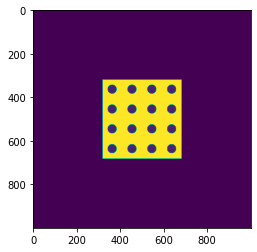

In [81]:
plt.imshow(abs(field0)**2)

(-3.141592653589793, 3.141592653589793)

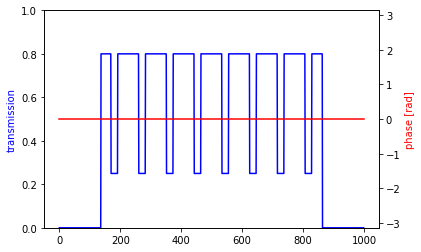

In [50]:
fig,ax1 = plt.subplots()
ax1.plot(range(pts), abs(field0[800,:]),color='blue')
ax1.set_ylabel("transmission",color='blue')
ax1.set_ylim((0,1))

ax2 = ax1.twinx()
ax2.plot(range(pts), angle(field0[800,:]),color='red')
ax2.set_ylabel("phase [rad]",color='red')
ax2.set_ylim((-pi,pi))

# plt.imshow(real(conjugate(field0)*field0))

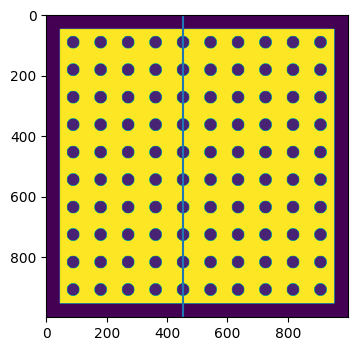

In [72]:
plt.close()
fig,ax = plt.subplots(dpi=100)
plt.imshow(abs(field0)**2)
ax.axvline(453)

In [95]:
# input mask
pts = 1000
phi_std=None # [rad]
pos_std=None
r_aper = .75 # aperture reflectivity
t_plate = 0.8 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)

# the half-width of the input field. start
size_steps = [(xnum1-i)*dx/2 for i in [-1,3,6]] # should start at i =-1 for full illum.
numsteps = len(size_steps)

In [96]:
[x/dx for x in size_steps]

[5.5, 3.5, 2.0]

In [97]:
I2max = 1

z2 = f2 # output plane

xslice = 453 # x coordinate of the slice
slices_soln = empty((pts,numsteps),dtype=float) 

for i,xhalfwidth in enumerate(size_steps):

    # partially illuminate the mask
    partial_field = set_region2d(np.zeros(mask.shape), x0pts, -xhalfwidth, xhalfwidth, 1)
    field0 = mask*partial_field

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding= int(pts/2) 
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                              logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                              logging=False)
    
    if i == 0:
        I2max = amax(abs(field2[:,xslice])**2)
    slices_soln[:,i] = abs(field2[:,xslice])**2/I2max
    print(f"step {i} completed")

step 0 completed
step 1 completed
step 2 completed


No handles with labels found to put in legend.


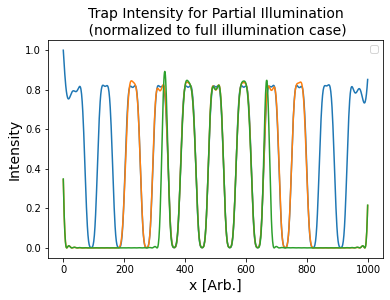

In [98]:
savefig=False
fig,ax = plt.subplots()
for i in range(numsteps):
    ax.plot(range(pts),slices_soln[:,i])
ax.set_title("Trap Intensity for Partial Illumination"+ "\n (normalized to full illumination case)",fontsize=fontsize)
ax.set_xlabel("x [Arb.]",fontsize=fontsize)
ax.set_ylabel("Intensity",fontsize=fontsize)
# ax.set_ylim((0,0.2))
# ax.set_xlim((430,480))
ax.legend()
if savefig:
    fname = f"plot_trap_profile_neg_spot_phase_tplate{int(100*t_plate)}_rspot{int(100*(1-r_aper))}_pi{abs(int(phase_steps[0]))}_pf{abs(int(phase_steps[-1]))}_{numsteps}pts.png"
    savefigure(fname)

In [101]:
f"plot_trap_min_vs_spot_phase_tplate{int(100*t_plate)}_rspot{int(100*(1-r_aper))}_{numsteps}pts.png"

'plot_trap_min_vs_spot_phase_tplate80_rspot25_101pts.png'

saved file to ..\images\plot_trap_min_vs_spot_phase_tplate80_rspot25_pi45_pf45_51pts.png


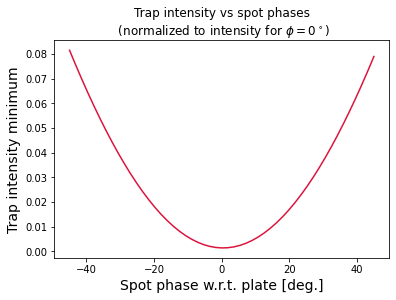

In [7]:
savefig=True
fig,ax = plt.subplots()
ax.set_title(r"Trap intensity vs spot phases" + "\n (normalized to intensity for $\phi=0^\circ$)" )
ax.set_xlabel("Spot phase w.r.t. plate [deg.]",fontsize=fontsize)
ax.set_ylabel(r"Trap intensity minimum",fontsize=fontsize)
ax.plot(phase_steps, [slices_soln[455,i] for i in range(numsteps)],color='crimson')
if savefig:
    fname = f"plot_trap_min_vs_spot_phase_tplate{int(100*t_plate)}_rspot{int(100*(1-r_aper))}_pi{abs(int(phase_steps[0]))}_pf{abs(int(phase_steps[-1]))}_{numsteps}pts.png"
    savefigure(fname)